In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import pathlib as pl
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = 'C:/Users/light/Documents/Fastbook/Personal-Machine-Learning-Data/'

In [2]:
data_dir = pl.Path(data_path + 'X Ray Images/images/')

In [3]:
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
IMG_SHAPE = IMAGE_SIZE + (3,)

In [4]:
train_df = pd.read_csv('X Ray Images/labels.csv')

In [5]:
train_df['Finding Labels'] = train_df['Finding Labels'].apply(lambda x:x.split('|'))

In [6]:
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion'
                 , 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass'
                 , 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']

In [7]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [8]:
train_ds = datagen.flow_from_dataframe(
     dataframe = train_df[:4000]
    ,directory = data_dir
    ,x_col = 'Image Index'
    ,y_col = 'Finding Labels'
    #,subset = 'training'
    ,class_mode = 'categorical'
    ,classes = class_names
    ,batch_size = BATCH_SIZE
    ,target_size = IMAGE_SIZE
)

Found 4000 validated image filenames belonging to 15 classes.


In [9]:
val_ds = datagen.flow_from_dataframe(
     dataframe = train_df[4000:5200]
    ,directory = data_dir
    ,x_col = 'Image Index'
    ,y_col = 'Finding Labels'
    #,subset = 'validation'
    ,class_mode = 'categorical'
    ,classes = class_names
    ,batch_size = BATCH_SIZE
    ,target_size = IMAGE_SIZE
)

Found 1200 validated image filenames belonging to 15 classes.


In [10]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

In [11]:
test_ds = test_datagen.flow_from_dataframe(
    dataframe = train_df[5200:]
    ,directory = data_dir
    ,x_col = 'Image Index'
    ,class_mode = None
    ,batch_size = BATCH_SIZE
    ,target_size = IMAGE_SIZE
)

Found 406 validated image filenames.


In [12]:
num_classes = len(class_names)

In [13]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


In [15]:
base_model.trainable = False

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(num_classes, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 15)


In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 1e-04
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [20]:
initial_epochs = 8

# loss0, accuracy0 = model.evaluate(val_ds)
# print("initial loss: {:.2f}".format(loss0))
# print("initial accuracy: {:.2f}".format(accuracy0))

In [21]:
history = model.fit_generator(
                    generator=train_ds
                    ,epochs=initial_epochs
                    ,validation_data=val_ds)

Epoch 1/8
63/63 [==============================] - 69s 1s/step - loss: 0.5006 - accuracy: 0.0948 - val_loss: 0.2943 - val_accuracy: 0.4158
Epoch 2/8
63/63 [==============================] - 63s 998ms/step - loss: 0.2594 - accuracy: 0.4922 - val_loss: 0.2456 - val_accuracy: 0.5108
Epoch 3/8
63/63 [==============================] - 60s 950ms/step - loss: 0.2333 - accuracy: 0.5422 - val_loss: 0.2370 - val_accuracy: 0.5117
Epoch 4/8
63/63 [==============================] - 60s 951ms/step - loss: 0.2268 - accuracy: 0.5465 - val_loss: 0.2345 - val_accuracy: 0.5117
Epoch 5/8
63/63 [==============================] - 54s 864ms/step - loss: 0.2248 - accuracy: 0.5447 - val_loss: 0.2323 - val_accuracy: 0.5125
Epoch 6/8
63/63 [==============================] - 54s 858ms/step - loss: 0.2210 - accuracy: 0.5480 - val_loss: 0.2311 - val_accuracy: 0.5125
Epoch 7/8
63/63 [==============================] - 54s 864ms/step - loss: 0.2209 - accuracy: 0.5480 - val_loss: 0.2306 - val_accuracy: 0.5125
Epoch 8/8

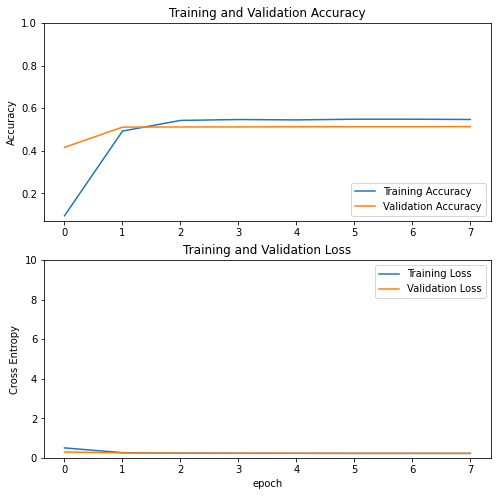

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,10.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
base_model.trainable = True

In [24]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [25]:
# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [26]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [27]:
len(model.trainable_variables)

56

In [28]:
fine_tune_epochs = 4
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit_generator(
                         generator=train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 8/12
63/63 [==============================] - 57s 851ms/step - loss: 0.2157 - accuracy: 0.5485 - val_loss: 0.2208 - val_accuracy: 0.5058
Epoch 9/12
63/63 [==============================] - 53s 836ms/step - loss: 0.2102 - accuracy: 0.5475 - val_loss: 0.2186 - val_accuracy: 0.5067
Epoch 10/12
63/63 [==============================] - 53s 838ms/step - loss: 0.2071 - accuracy: 0.5495 - val_loss: 0.2222 - val_accuracy: 0.5108
Epoch 11/12
63/63 [==============================] - 53s 847ms/step - loss: 0.2047 - accuracy: 0.5533 - val_loss: 0.2171 - val_accuracy: 0.5075
Epoch 12/12
63/63 [==============================] - 54s 857ms/step - loss: 0.2030 - accuracy: 0.5510 - val_loss: 0.2217 - val_accuracy: 0.5117


In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

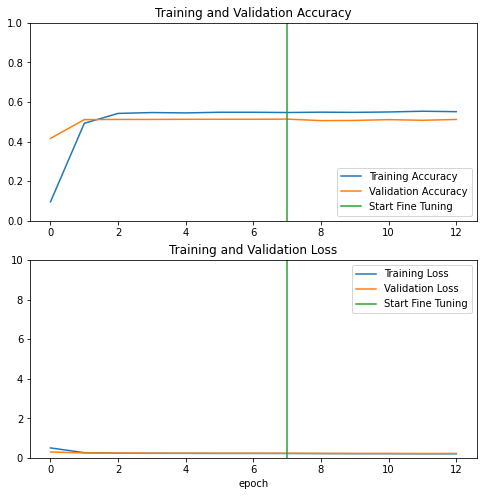

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 10.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
test_ds.reset()
pred=model.predict_generator(test_ds,
verbose=1)

7/7 [==============================] - 7s 930ms/step


In [23]:
pred_bool = (pred > 0.5)

In [24]:
predictions=[]
labels = train_ds.class_indices
labels = dict((v,k) for k,v in labels.items())
for row in pred_bool:
    l=[]
    for index,cls in enumerate(row):
        if cls:
            l.append(labels[index])
    predictions.append(",".join(l))
filenames=test_ds.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})
#results.to_csv("results.csv",index=False)

In [25]:
results

,Filename,Predictions
0,00027757_000.png,No Finding
1,00027757_002.png,No Finding
2,00027763_001.png,
3,00027765_000.png,No Finding
4,00027782_002.png,
...,...,...
401,00030712_000.png,No Finding
402,00030786_005.png,
403,00030789_000.png,No Finding
404,00030792_000.png,No Finding


In [26]:
model.save('x_ray_keras_mobilenet_v2')

INFO:tensorflow:Assets written to: x_ray_keras_mobilenet_v2\assets


In [27]:
new_model = tf.keras.models.load_model('x_ray_keras_mobilenet_v2')

In [28]:
import tf2onnx
import onnxruntime as rt

In [29]:
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
output_path = "x_ray_keras_mobilenet_v2.onnx"

model_proto, _ = tf2onnx.convert.from_keras(new_model, input_signature=spec, output_path=output_path)
output_names = [n.name for n in model_proto.graph.output]

Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


In [32]:
from tensorflow.keras.preprocessing import image
img_path = 'X Ray Images/images/00000017_001.png'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [33]:
providers = ['CPUExecutionProvider']
m = rt.InferenceSession(output_path, providers=providers)
onnx_pred = m.run(output_names, {"input": x})

#onnx_pred= tf.math.argmax(onnx_pred[0], axis=1)

print('ONNX Predicted:', onnx_pred)

# make sure ONNX and keras have the same results
#np.testing.assert_allclose(preds, onnx_pred)

ONNX Predicted: [array([[4.2935941e-02, 1.0199892e-02, 2.0113846e-02, 1.8554997e-02,
        8.4862262e-02, 6.0551665e-03, 4.1497136e-03, 2.3654129e-08,
        8.7445587e-02, 3.4770187e-02, 6.5092003e-01, 1.0828029e-02,
        3.8091682e-03, 7.7331281e-04, 2.4581844e-02]], dtype=float32)]
